In [122]:
%reset -f

import sys
import os
import bz2
import csv
import pandas as pd
import ast
import ujson
import numpy as np

import datashader as ds
import datashader.transfer_functions as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ENCODING = "UTF-8"

# dirpath = "Data/OTCamera/"
# filename = "Testvideo_Cars-Cyclist_FR20_2020-01-01_00-00-00"
dirpath = "Z:/04_Daten/GroundThruth/Fussverkehrausfkommen/OTC07_23-09-19_17-00-00/"
filename = "OTCamera07_FR20_2023-09-19_17-00-00_Sued"
fileending = '.ottrk'
filepath = os.path.join(dirpath, filename) + fileending

In [179]:
def ottrk_to_txt(filepath, key1 = 'data', key2 = 'detections'):
    # Open ottrk-file
    with bz2.open(filepath, "rt", encoding=ENCODING) as file:
        dictfile = ujson.load(file)
    
    # Write in DataFrame
    detections = pd.DataFrame.from_dict(dictfile[key1][key2])
    detections = detections[['x', 'y', 'w', 'h', 'frame', 'track-id', 'class']] #bb_left = x, bb_top = y

    # Transform to MOTChallenge-format (x,y,z are ignored fpr 2D-challenges)
    # MOTdetections = detections
    # MOTdetections['conf'] = 1
    # MOTdetections['3D_x'] = -1
    # MOTdetections['3D_y'] = -1
    # MOTdetections['3D_z'] = -1
    # MOTdetections = MOTdetections[['frame', 'track-id', 'x', 'y', 'h', 'w', 'conf', '3D_x', '3D_y', '3D_z']]

    # Export
    # MOTdetections.to_csv(dirpath + filename + '.txt', encoding='utf-8', header=False, index=False)

    return detections

OTCdetections = ottrk_to_txt(filepath = filepath)

OTCdetections['sec'] = (OTCdetections['frame'] - OTCdetections['frame'].min()) / 20 #20fps
OTCdetections = OTCdetections[OTCdetections['class'] == 'pedestrian'].sort_values(['track-id', 'frame']).reset_index(drop=True)
# OTCdetections = OTCdetections.sort_values(['track-id', 'frame']).reset_index(drop=True)

In [134]:
# Frames filtern

# data = detections[detections['frame'] >=3380]
# data = data[data['frame'] <=5000]


# print(OTCdetections.groupby(['track-id'])['track-id'].count())
# print(data['track-id'].value_counts())
# data = data[data['track-id'] == 14476]

## Trajektorienlänge

In [180]:
OTCdetections['dx'] = 0
OTCdetections['dy'] = 0

# Richtungsvektor
for i in range(len(OTCdetections)):
    if i < len(OTCdetections)-1:
        OTCdetections.loc[i+1, 'dx'] = OTCdetections.loc[i+1, 'x'] - OTCdetections.loc[i, 'x']
        OTCdetections.loc[i+1, 'dy'] = OTCdetections.loc[i+1, 'y'] - OTCdetections.loc[i, 'y']
OTCdetections['d_l'] = np.sqrt(np.power(OTCdetections['dx'],2) + np.power(OTCdetections['dy'],2))

# Ersten Wert von d_l für jede track.-id = 0 setzen
def replace_first_value(group):
    if group.iloc[0] != 0:
        group.iloc[0] = 0
    return group

OTCdetections['dx'] = OTCdetections.groupby('track-id')['dx'].apply(replace_first_value).reset_index(level=0, drop=True)
OTCdetections['dy'] = OTCdetections.groupby('track-id')['dy'].apply(replace_first_value).reset_index(level=0, drop=True)
OTCdetections['d_l'] = OTCdetections.groupby('track-id')['d_l'].apply(replace_first_value).reset_index(level=0, drop=True)

tracklength = pd.DataFrame(OTCdetections.groupby('track-id')['d_l'].sum().sort_values(ascending = False))
tracklength['track-length'] = tracklength['d_l']
del tracklength['d_l']

# Rolling mean
OTCdetections = pd.merge(OTCdetections, tracklength, on='track-id')

TypeError: incompatible index of inserted column with frame index

## Plotting

### matplotlib

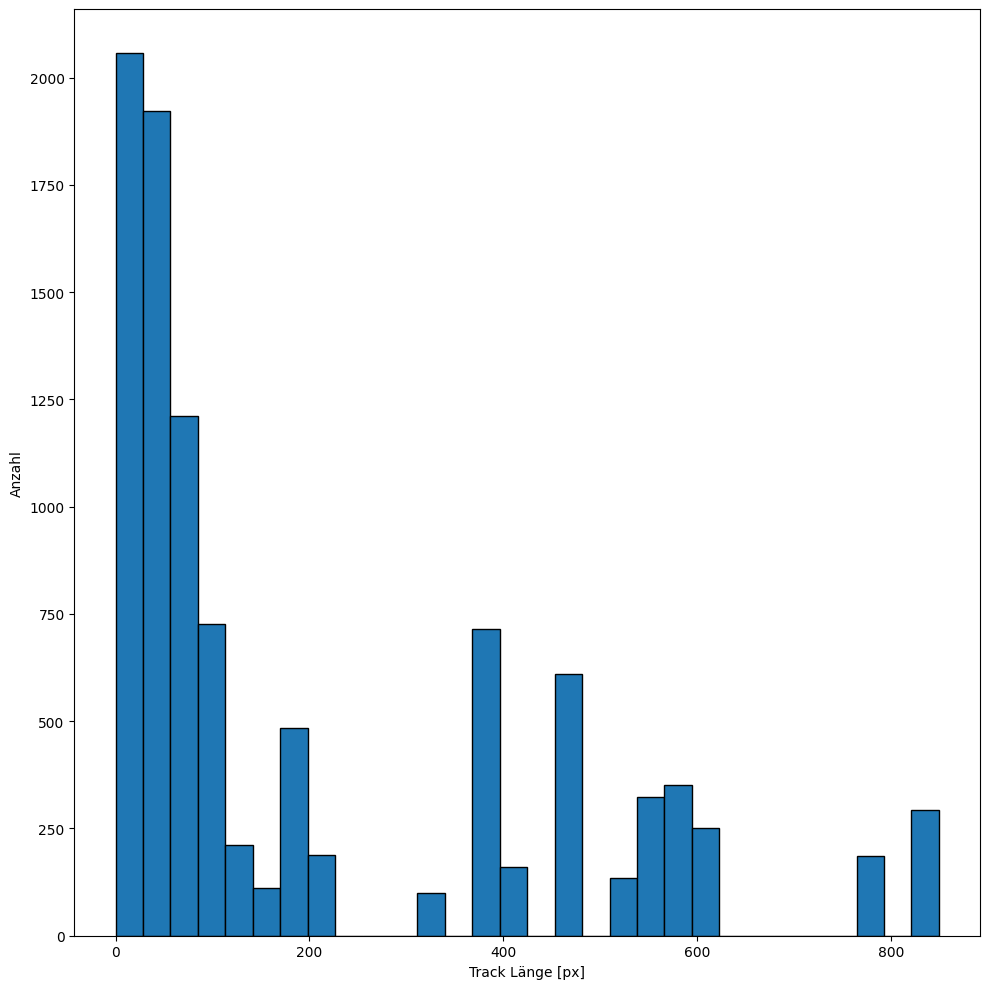

In [157]:
# Histogramm erstellen
plt.hist(OTCdetections['track-length'], bins=30, edgecolor='black')
plt.xlabel('Track Länge [px]')
plt.ylabel('Anzahl')
plt.show()


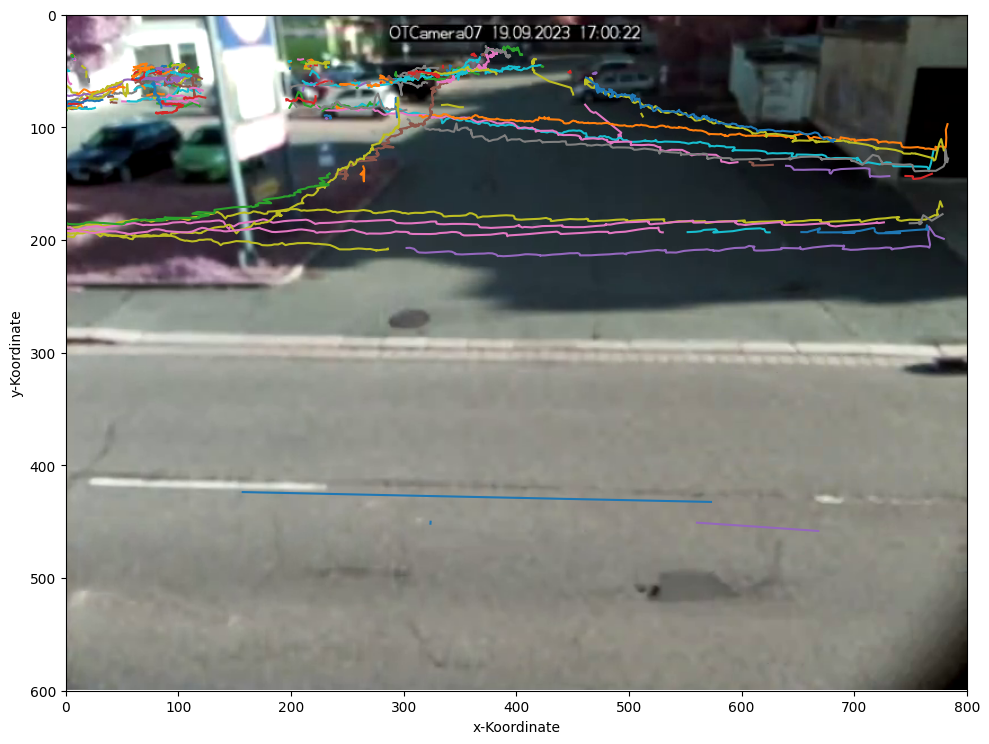

In [148]:
data = OTCdetections[OTCdetections['class'] == 'pedestrian']

# Hintergrundbild
background = mpimg.imread(dirpath + "Screenshot.png")

# Den DataFrame nach 'track-id' gruppieren
grouped_df = data.groupby('track-id')

# Iteration durch die Gruppen und Plotten der Trajektorien
for group_name, group_df in grouped_df:
    x = group_df['x']
    y = group_df['y']
    plt.plot(x, y, label=f'Track ID: {group_name}')

# Plot-Einstellungen
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.xlabel('x-Koordinate') 




plt.ylabel('y-Koordinate')
# plt.legend()

plt.xlim(0, 800)
plt.ylim(0, 600)
plt.gca().invert_yaxis()
plt.imshow(background)
plt.savefig("test.svg")
plt.show()

## Import otevents

In [58]:
## OTEvents

eventscsv = pd.read_csv(dirpath + 'events.csv')
eventscsv = eventscsv[eventscsv['road_user_type'] == 'pedestrian']

def events_to_txt(filepath, key1 = 'sections', key2 = 'event_list'):
    # Open ottrk-file
    with bz2.open(filepath, "rt", encoding=ENCODING) as file:
        dictfile = ujson.load(file)

    # Write in DataFrame
    sections = pd.DataFrame.from_dict(dictfile['sections'])
    events = pd.DataFrame.from_dict(dictfile['event_list'])
    # detections = detections[['x', 'y', 'w', 'h', 'frame', 'track-id', 'class']] #bb_left = x, bb_top = y


    # Export
    # MOTdetections.to_csv(dirpath + filename + '.txt', encoding='utf-8', header=False, index=False)

    return sections, events
sections, events = events_to_txt(filepath = dirpath + 'events.otevents')

events = events[events['road_user_type'] == 'pedestrian']

# Identifikation mangelhafter Trajektorien

#### TrackS brechen mittendrin ab oder tauchen mittendrin auf
- "Innere Box" definieren, innerhalb welcher auftauchende/abbrechende Tracks als fehlerhaft gelten
    - Wenn (fast) alle Tracks aus einer Richtung in der Box beginnnen scheint es kein Detektions- bzw. Trackerfehler zu sein
    - Bild in Quadranten unterteilen und Häufigkeit von trackendn / -ende auswerten?

In [ ]:
## Tracks in Quadranten (50x50 px) unterteilen
test = OTCdetections

def quadrant(p, l = 2000, d = 100):
    for r in range(0, l, d):
        if p >= r and p < r + d:
            return (r / d)

trackbegin = test
trackbegin['tracks'] = trackbegin['track-id']
trackbegin = trackbegin.groupby('track-id').first().reset_index(drop=True)
trackbegin['Quadrant_begin'] = trackbegin['x'].apply(quadrant).astype(int).astype(str) + '_' + trackbegin['y'].apply(quadrant).astype(int).astype(str)
trackbegin = trackbegin[['tracks', 'Quadrant_begin']]

trackend = OTCdetections
trackend['tracks'] = trackend['track-id']
trackend = trackend.groupby('track-id').last().reset_index(drop=True)
trackend['Quadrant_end'] = trackend['x'].apply(quadrant).astype(int).astype(str) + '_' + trackend['y'].apply(quadrant).astype(int).astype(str)
trackend = trackend[['tracks', 'Quadrant_end']]

OTCdetections = pd.merge(OTCdetections, trackbegin, how = 'left', left_on='track-id', right_on='tracks')
OTCdetections = pd.merge(OTCdetections, trackend, how = 'left', left_on='track-id', right_on='tracks')
del OTCdetections['tracks'], OTCdetections['tracks_x'], OTCdetections['tracks_y'], test, trackbegin, trackend

trackends = 0

- Position der BB-Ecken

In [173]:
test = OTCdetections

test['BB_links_x'] = test['x'] - (test['w'] / 2)
test['BB_rechts_x'] = test['x'] + (test['w'] / 2)
test['BB_oben_y'] = test['y'] - (test['h'] / 2)
test['BB_unten_y'] = test['y'] + (test['h'] / 2)

- plots

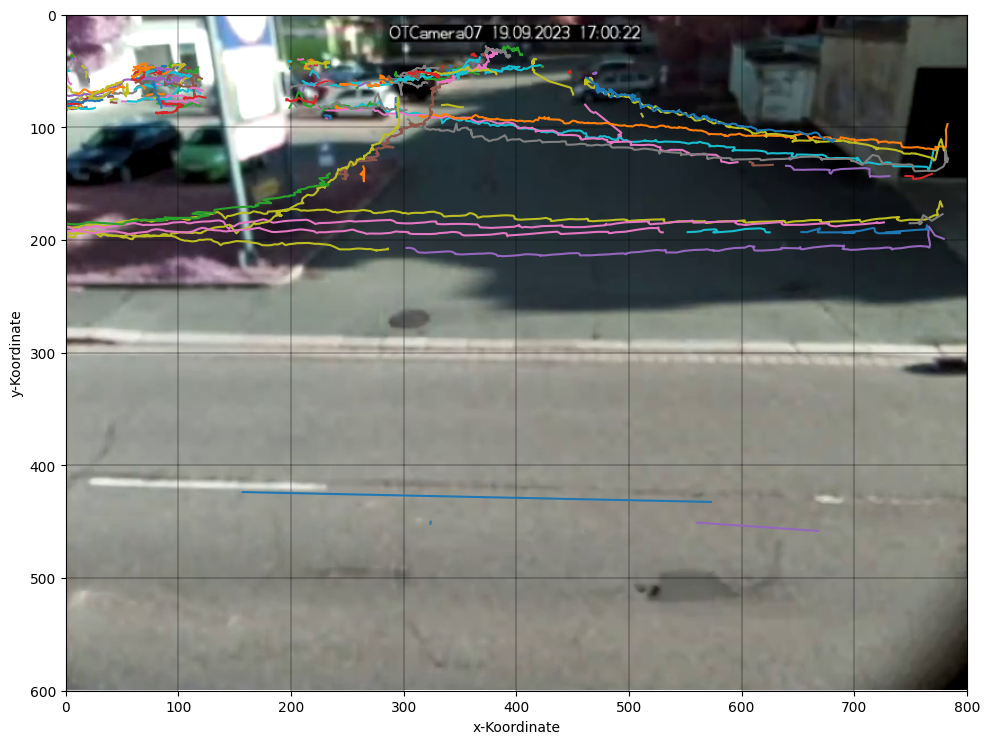

In [160]:
data = test#[test['track-length'] <= 500]
Quadranten = pd.DataFrame(
    {'x': [0,0,100,100, 200,200,300,300,400,400,500,500,600,600,700,700,800,800,0,0,800,800,0,0,800,800,0],
     'y': [0,600,600,0, 0,600,600,0,    0,600,600,0,    0,600,600,0,    0,500,500,400,400,300,300,200,200,100,100],
     'track-id': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
)
background = mpimg.imread(dirpath + "Screenshot.png")
plt.plot(Quadranten['x'], Quadranten['y'], color='black',linewidth=0.3)
grouped_df = data.groupby('track-id')
for group_name, group_df in grouped_df:
    x = group_df['x']
    y = group_df['y']
    plt.plot(x, y, label=f'Track ID: {group_name}')
    
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.xlabel('x-Koordinate') 
plt.ylabel('y-Koordinate')
plt.xlim(0, 800)
plt.ylim(0, 600)
plt.gca().invert_yaxis()
plt.imshow(background)
# plt.savefig("test.svg")
plt.show()